# General imports

In [ ]:
import sys, os
import json
import urllib
from datetime import datetime
from time import time
from urllib.request import urlopen
from statistics import median, mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import requests

# Financials class

In [ ]:
from datetime import datetime
from typing import Dict
from functools import reduce

import pandas as pd
import numpy as np

pd.options.display.float_format = "{:.2f}".format
pd.options.mode.chained_assignment = None

np.set_printoptions(suppress=True, formatter={"float_kind": "{:f}".format}, precision=2)


class Financials:
    def __init__(self, income_statement_json, balance_sheet_json, cash_flow_json, ticker):
        def __get_year(date):
            return pd.Timestamp(date).year

        self.ticker = ticker

        df_income_statement = pd.DataFrame(income_statement_json)
        df_income_statement_clean = df_income_statement[
            [
                "date",
                "revenue",
                "grossProfit",
                "netIncome",
                "incomeTaxExpense",
                "interestExpense",
                "weightedAverageShsOut",
                "weightedAverageShsOutDil",
                "eps",
                "epsdiluted",
            ]
        ]
        df_income_statement_clean.set_index("date", inplace=True)

        df_balance_sheet = pd.DataFrame(balance_sheet_json)
        df_balance_sheet_clean = df_balance_sheet[
            [
                "date",
                "shortTermDebt",
                "longTermDebt",
                "totalDebt",
                "cashAndCashEquivalents",
                "shortTermInvestments",
                "totalStockholdersEquity",
                "totalAssets",
                "totalLiabilities",
            ]
        ]
        df_balance_sheet_clean.set_index("date", inplace=True)

        self.df_accounting = df_income_statement_clean.merge(
            df_balance_sheet_clean, left_index=True, right_index=True
        )

        df_cash_flow_statement = pd.DataFrame(cash_flow_json)
        df_cash_flow_statement_clean = df_cash_flow_statement[
            ["date", "depreciationAndAmortization", "freeCashFlow"]
        ]
        df_cash_flow_statement_clean.set_index("date", inplace=True)

        self.df_accounting = self.df_accounting.merge(
            df_cash_flow_statement_clean, left_index=True, right_index=True
        )

        self.df_accounting.reset_index(inplace=True)

        self.df_accounting["year"] = self.df_accounting["date"].apply(__get_year)

    def get_last_statement_date(self):
        statement_date = self.df_accounting["date"].max()
        return statement_date

    def get_first_statment_date(self):
        statement_date = self.get_last_statement_date()
        return self.df_accounting.loc[self.df_accounting["date"] < statement_date]["date"].iloc[0]

    def get_last_revenue(self):
        statement_date = self.get_last_statement_date()
        return round(
            self.df_accounting.loc[self.df_accounting["date"] == statement_date]["revenue"].iloc[0],
            2,
        )


# Fundamentals class

In [ ]:
from datetime import datetime
from typing import Dict
from functools import reduce

from statistics import mean

import sys, os

import pandas as pd
import numpy as np

pd.options.display.float_format = "{:.2f}".format
pd.options.mode.chained_assignment = None

np.set_printoptions(suppress=True, formatter={"float_kind": "{:f}".format}, precision=2)


class Fundamentals:
    def __init__(self, df_financials_with_stock_price, ticker):
        try:
            self.df_fundamentals = df_financials_with_stock_price
            self.ticker = ticker

            self.__get_ebitda_historical()
            self.__get_ebit_historical()
            self.__get_marketcap_historical()
            self.__get_enterprise_value_historical()
            self.__get_per_historical()
            self.__get_ev_ebitda_historical()
            self.__get_ev_ebit_historical()
            self.__get_ev_fcf_historical()
            self.__get_margin_gross_historical()
            self.__get_margin_ebit_historical()
            self.__get_margin_fcf_historical()
            self.__get_margin_net_historical()
            self.__get_revenue_per_share_historical()
            self.__get_ebitda_per_share_historical()
            self.__get_ebit_per_share_historical()
            self.__get_fcf_per_share_historical()
            self.__get_pct_change()
            # self.__get_linear_regression_forecast()
            self.statement_date = self.df_fundamentals["date"].max()
            self.first_statement_date = self.df_fundamentals.loc[
                self.df_fundamentals["date"] < self.statement_date
            ]["date"].iloc[0]

        except (Exception) as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)

    def __get_ebitda_historical(self):
        self.df_fundamentals["EBITDA"] = (
            self.df_fundamentals["netIncome"]
            + self.df_fundamentals["interestExpense"]
            + self.df_fundamentals["incomeTaxExpense"]
            + self.df_fundamentals["depreciationAndAmortization"]
        )

    def __get_ebit_historical(self):
        self.df_fundamentals["EBIT"] = (
            self.df_fundamentals["netIncome"]
            + self.df_fundamentals["interestExpense"]
            + self.df_fundamentals["incomeTaxExpense"]
        )

    def __get_marketcap_historical(self):
        self.df_fundamentals["marketcap"] = (
            self.df_fundamentals["weightedAverageShsOut"] * self.df_fundamentals["price"]
        )

    def __get_enterprise_value_historical(self):
        self.df_fundamentals["enterprise_value"] = (
            self.df_fundamentals["marketcap"]
            + self.df_fundamentals["totalDebt"]
            - (
                self.df_fundamentals["cashAndCashEquivalents"]
                + self.df_fundamentals["shortTermInvestments"]
            )
        )

    def __get_per_historical(self):
        self.df_fundamentals["per"] = (
            self.df_fundamentals["price"] / self.df_fundamentals["epsdiluted"]
        )

    def __get_ev_ebitda_historical(self):
        self.df_fundamentals["EV_EBITDA"] = (
            self.df_fundamentals["enterprise_value"] / self.df_fundamentals["EBITDA"]
        )

    def __get_ev_ebit_historical(self):
        self.df_fundamentals["EV_EBIT"] = (
            self.df_fundamentals["enterprise_value"] / self.df_fundamentals["EBIT"]
        )

    def __get_ev_fcf_historical(self):
        self.df_fundamentals["EV_FCF"] = (
            self.df_fundamentals["enterprise_value"] / self.df_fundamentals["freeCashFlow"]
        )

    def __get_margin_gross_historical(self):
        self.df_fundamentals["margin_gross"] = (
            round(self.df_fundamentals["grossProfit"] / self.df_fundamentals["revenue"], 2) * 100
        )

    def __get_margin_ebit_historical(self):
        self.df_fundamentals["margin_ebit"] = (
            round(self.df_fundamentals["EBIT"] / self.df_fundamentals["revenue"], 2) * 100
        )

    def __get_margin_net_historical(self):
        self.df_fundamentals["margin_net"] = (
            round(self.df_fundamentals["netIncome"] / self.df_fundamentals["revenue"], 2) * 100
        )

    def __get_margin_fcf_historical(self):
        self.df_fundamentals["margin_fcf"] = (
            round(self.df_fundamentals["freeCashFlow"] / self.df_fundamentals["revenue"], 2) * 100
        )

    def __get_revenue_per_share_historical(self):
        self.df_fundamentals["revenue_per_share"] = round(
            self.df_fundamentals["revenue"] / self.df_fundamentals["weightedAverageShsOutDil"], 2
        )

    def __get_ebitda_per_share_historical(self):
        self.df_fundamentals["ebitda_per_share"] = (
            self.df_fundamentals["EBITDA"] / self.df_fundamentals["weightedAverageShsOutDil"]
        )

    def __get_ebit_per_share_historical(self):
        self.df_fundamentals["ebit_per_share"] = (
            self.df_fundamentals["EBIT"] / self.df_fundamentals["weightedAverageShsOutDil"]
        )

    def __get_fcf_per_share_historical(self):
        self.df_fundamentals["fcf_per_share"] = (
            self.df_fundamentals["freeCashFlow"] / self.df_fundamentals["weightedAverageShsOutDil"]
        )

    def __get_pct_change(self):
        self.df_fundamentals = self.df_fundamentals.iloc[::-1]
        self.df_fundamentals["revenue_per_share_growth"] = self.df_fundamentals[
            "revenue_per_share"
        ].pct_change()
        self.df_fundamentals["ebitda_per_share_growth"] = self.df_fundamentals[
            "ebitda_per_share"
        ].pct_change()
        self.df_fundamentals["ebit_per_share_growth"] = self.df_fundamentals[
            "ebit_per_share"
        ].pct_change()
        self.df_fundamentals["fcf_per_share_growth"] = self.df_fundamentals[
            "fcf_per_share"
        ].pct_change()
        self.df_fundamentals["eps_growth"] = self.df_fundamentals["eps"].pct_change()
        self.df_fundamentals["epsdiluted_growth"] = self.df_fundamentals["epsdiluted"].pct_change()
        self.df_fundamentals.fillna(0, inplace=True)

    def __get_linear_regression_forecast(self):

        df_forecast_fcf = self.__get_forecast("freeCashFlow")
        df_forecast_netIncome = self.__get_forecast("netIncome")
        df_forecast_ebitda = self.__get_forecast("EBITDA")
        df_forecast_ebit = self.__get_forecast("EBIT")
        df_forecast_eps = self.__get_forecast("eps")
        df_forecast_eps_diluted = self.__get_forecast("epsdiluted")
        df_forecast_revenue = self.__get_forecast("revenue")

        df_forecast_metrics = [
            df_forecast_fcf,
            df_forecast_netIncome,
            df_forecast_ebitda,
            df_forecast_ebit,
            df_forecast_eps,
            df_forecast_eps_diluted,
            df_forecast_revenue,
        ]

        def __get_year(date):
            return pd.Timestamp(date).year

        try:
            df_merged = reduce(
                lambda left, right: pd.merge(left, right, on=["date"], how="outer"),
                df_forecast_metrics,
            ).fillna("void")
            df_merged["year"] = df_merged["date"].apply(__get_year)
            df_merged.set_index("year", inplace=True)
            self.df_fundamentals = pd.concat([self.df_fundamentals, df_merged], axis=0)
            self.df_fundamentals.fillna(0, inplace=True)
        except (Exception) as e:
            print("fail during linear regression forecast")
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)

    def __get_forecast(self, metric):
        df = self.df_fundamentals.loc[self.df_fundamentals[metric] != 0][["date", metric]]
        df.reset_index(inplace=True)
        df.rename(columns={"index": "date"}, inplace=True)
        df.rename(columns={0: metric}, inplace=True)
        df.reset_index(inplace=True)
        try:
            x = df["index"].to_numpy()
            y = df[metric].to_numpy()

            y_future = ForecastLR.get_forecast(x, y)

            def __get_year(date):
                return pd.Timestamp(date).year

            def __get_month(date):
                return pd.Timestamp(date).month

            def __get_day(date):
                return pd.Timestamp(date).day

            year = __get_year(df["date"].max())
            month = __get_month(df["date"].max())
            day = __get_day(df["date"].max())
        except (Exception) as e:
            print(e)

        try:
            forecast_list = list()
            df_forecast = pd.DataFrame()

            for j in range(0, y_future.size):
                year = year + 1
                my_date = f"{year}-{month}-{day}"
                forecasting_dict = dict(
                    {"year": year, "date": my_date, metric: float(round(y_future[j][0], 2)),}
                )
                forecast_list.append(forecasting_dict)

            df_forecast = pd.DataFrame(forecast_list)
            df_forecast.set_index("year", inplace=True)

            return df_forecast

        except (Exception) as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)

    def __get_last_data(self, metric):
        return round(
            self.df_fundamentals.loc[self.df_fundamentals["date"] == self.statement_date][
                metric
            ].iloc[0],
            2,
        )

    def get_last_revenue(self):
        return self.__get_last_data("revenue")

    def get_last_revenue_per_share(self):
        return self.__get_last_data("revenue_per_share")

    def get_last_fcf_per_share(self):
        return self.__get_last_data("fcf_per_share")

    def get_last_ebit_per_share(self):
        return self.__get_last_data("ebit_per_share")

    def get_last_ebitda_per_share(self):
        return self.__get_last_data("ebitda_per_share")

    def get_last_net_income(self):
        return self.__get_last_data("netIncome")

    def get_last_income_tax_expenses(self):
        return self.__get_last_data("incomeTaxExpense")

    def get_last_depreciationAndAmortization(self):
        return self.__get_last_data("depreciationAndAmortization")

    def get_last_freeCashFlow(self):
        return self.__get_last_data("freeCashFlow")

    def get_last_interestExpense(self):
        return self.__get_last_data("interestExpense")

    def get_last_totalStockholdersEquity(self):
        return self.__get_last_data("totalStockholdersEquity")

    def get_last_shortTermDebt(self):
        return self.__get_last_data("shortTermDebt")

    def get_last_longTermDebt(self):
        return self.__get_last_data("longTermDebt")

    def get_last_totalAssets(self):
        return self.__get_last_data("totalAssets")

    def get_last_totalLiabilities(self):
        return self.__get_last_data("totalLiabilities")

    def get_last_ebit(self):
        return self.__get_last_data("EBIT")

    def get_last_eps_diluted(self):
        return self.__get_last_data("epsdiluted")

    def get_last_gross_margin(self):
        return self.__get_last_data("margin_gross")

    def get_last_margin_ebit(self):
        return self.__get_last_data("margin_ebit")

    def get_last_margin_net(self):
        return self.__get_last_data("margin_net")

    def get_last_margin_fcf(self):
        return self.__get_last_data("margin_fcf")

    def get_radar_margin(self):
        margin_gross = self.__get_last_data("margin_gross")
        margin_ebit = self.__get_last_data("margin_ebit")
        margin_net = self.__get_last_data("margin_net")
        margin_fcf = self.__get_last_data("margin_fcf")

        margin_gross_rating = 0.0
        margin_ebit_rating = 0.0
        margin_net_rating = 0.0
        margin_fcf_rating = 0.0

        if margin_gross >= 40:
            margin_gross_rating = 2.0
        elif margin_gross >= 20 and margin_gross <= 39:
            margin_gross_rating = 1.0
        else:
            margin_gross_rating = 0.0

        if margin_ebit >= 20:
            margin_ebit_rating = 2.0
        elif margin_ebit > 10 and margin_ebit <= 19:
            margin_ebit_rating = 1.0
        else:
            margin_ebit_rating = 0.0

        if margin_net >= 20:
            margin_net_rating = 2.0
        elif margin_net > 10 and margin_net <= 19:
            margin_net_rating = 1.0
        else:
            margin_net_rating = 0.0

        if margin_fcf >= 16:
            margin_fcf_rating = 2.0
        elif margin_fcf > 6 and margin_fcf <= 15:
            margin_fcf_rating = 1.0
        else:
            margin_fcf_rating = 0.0

        return mean([margin_gross_rating, margin_ebit_rating, margin_net_rating, margin_fcf_rating])

    def get_last_ebitda(self):
        return self.__get_last_data("EBITDA")

    def get_last_marketcap(self):
        return self.__get_last_data("marketcap")

    def get_last_weightedAverageShsOut(self):
        return self.__get_last_data("weightedAverageShsOut")

    def get_last_cashAndCashEquivalents(self):
        return self.__get_last_data("cashAndCashEquivalents")

    def get_last_totalDebt(self):
        return self.__get_last_data("totalDebt")

    def get_last_shortTermInvestments(self):
        return self.__get_last_data("shortTermInvestments")

    def get_eps_historical(self):
        return self.df_fundamentals["epsdiluted"].round(2)

    def get_ebit_per_share_historical(self):
        return self.df_fundamentals["ebit_per_share"].round(2)

    def get_revenue_per_share_historical(self):
        return self.df_fundamentals["revenue_per_share"].round(2)

    def get_fcf_per_share_historical(self):
        return self.df_fundamentals["fcf_per_share"].round(2)

    def get_radar_growth(self):
        return 2.0


# Valuation class

In [ ]:
import sys, os
from typing import Dict

from datetime import datetime

import pandas as pd
import numpy as np


class Valuation:
    def __init__(self, df_financials_with_stock_price, ticker):
        self.df_fundamentals = df_financials_with_stock_price
        self.ticker = ticker

        try:
            self.statement_date = self.df_fundamentals["date"].max()
            self.five_years_ago_date = self.df_fundamentals.loc[
                self.df_fundamentals["date"] < self.statement_date
            ][
                "date"
            ].min()  # .iloc[0]
        except (Exception) as e:
            print("Error raise inside the valuation object builder")
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)

    def __get_median_five_years(self, multiple):
        return round(
            self.df_fundamentals.loc[self.df_fundamentals[multiple] != 0][multiple].median(), 2,
        )

    def __get_growth_cagr_last_five_years(self, metric):
        last_reported = self.df_fundamentals.loc[
            self.df_fundamentals["date"] == self.statement_date
        ][metric].iloc[0]
        five_years_ago = self.df_fundamentals.loc[
            self.df_fundamentals["date"] == self.five_years_ago_date
        ][metric].iloc[0]

        last_reported = round(last_reported, 2)
        five_years_ago = round(five_years_ago, 2)

        if five_years_ago <= 0.0:
            cagr_five_years = 0.0
        else:
            cagr_five_years = round((((last_reported / five_years_ago) ** (1 / 5)) - 1), 2)
        # CAGR adjusted (dealing with negative numbers) http://fortmarinus.com/blog/1214/
        # if five_years_ago <= 0.0:
        #    cagr_five_years_adjusted = 0.0
        # else:
        #    cagr_five_years_adjusted = round(
        #        (
        #            (((last_reported - five_years_ago) + abs(five_years_ago)) / abs(five_years_ago))
        #            ** (1.0 / 5.0)
        #        )
        #        - 1.0,
        #        2,
        #    )

        return cagr_five_years

    def __get_cagr(self, numerator, denominator):
        if denominator <= 0.0:
            return 0.0
        else:
            cagr = round(
                ((((numerator - denominator) + abs(denominator)) / abs(denominator)) ** (1.0 / 5.0))
                - 1.0,
                2,
            )
            return cagr

    def __get_five_years_forecast(self, metric):

        last_reported = self.df_fundamentals.loc[
            self.df_fundamentals["date"] == self.statement_date
        ][metric].iloc[0]

        if last_reported <= 0.0:
            return 0.0

        # print(f"{self.ticker} {metric} in {self.statement_date} is {last_reported}")

        growth_cagr = self.__get_growth_cagr_last_five_years(metric)
        # print(f"{self.ticker} {metric} GROWTH CAGR: {growth_cagr}")
        growth_cagr_reduced = round(growth_cagr / 1.25, 2)
        # print(f"{self.ticker} {metric} GROWTH CAGR REDUCED: {growth_cagr_reduced}")
        five_years_forecast = round((last_reported * growth_cagr_reduced * 5) + last_reported, 2)

        # print(f"{self.ticker} {metric} in five years is {five_years_forecast}")

        return five_years_forecast

    def __get_stock_price_five_years_forecast(self, metric, multiple):
        try:
            median = self.__get_median_five_years(multiple)
            # print(f"{self.ticker} {multiple}: {median}")
            median_reduced = round(median - (median * 0.10), 2)

            five_years_forecast = self.__get_five_years_forecast(metric)
            # print(f"{self.ticker} price_{metric}_five_years: {five_years_forecast}")

            price_five_years = round(five_years_forecast * median, 2)

            # print(f"{self.ticker} price_{multiple}_five_years: {price_five_years}")
            return price_five_years

        except (Exception) as e:
            print(
                f"Error raise during {self.ticker} __get_stock_price_five_years_forecast calculation"
            )
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)

    def __get_last_data(self, metric):
        return round(
            self.df_fundamentals.loc[self.df_fundamentals["date"] == self.statement_date][
                metric
            ].iloc[0],
            2,
        )

    def get_last_enterprise_value(self):
        return self.__get_last_data("enterprise_value")

    def get_last_ev_ebitda(self):
        return self.__get_last_data("EV_EBITDA")

    def get_last_ev_ebit(self):
        return self.__get_last_data("EV_EBIT")

    def get_last_ev_fcf(self):
        return self.__get_last_data("EV_FCF")

    def get_last_per(self):
        return self.__get_last_data("per")

    # PRICE PER
    def get_per_median_five_years(self):
        return self.__get_median_five_years("per")

    def get_eps_growth_cagr_last_five_years(self):
        return self.__get_growth_cagr_last_five_years("epsdiluted")

    def get_eps_five_years_forecast(self):
        return self.__get_five_years_forecast("epsdiluted")

    def get_stock_price_five_years_forecast_pe(self):
        return self.__get_stock_price_five_years_forecast("epsdiluted", "per")

    def get_price_five_years_forecast_pe_cagr(self, current_price):
        future_price = self.__get_stock_price_five_years_forecast("epsdiluted", "per")
        return self.__get_cagr(future_price, current_price)

    # Price EV/FCF
    def get_ev_fcf_median_five_years(self):
        return self.__get_median_five_years("EV_FCF")

    def get_fcf_per_share_growth_cagr_last_five_years(self):
        return self.__get_growth_cagr_last_five_years("fcf_per_share")

    def get_fcf_per_share_five_years_forecast(self):
        return self.__get_five_years_forecast("fcf_per_share")

    def get_stock_price_five_years_forecast_ev_fcf(self):
        return self.__get_stock_price_five_years_forecast("fcf_per_share", "EV_FCF")

    def get_price_five_years_forecast_ev_fcf_cagr(self, current_price):
        future_price = self.__get_stock_price_five_years_forecast("fcf_per_share", "EV_FCF")
        return self.__get_cagr(future_price, current_price)

    # Price EV/EBITDA
    def get_ev_ebitda_median_five_years(self):
        return self.__get_median_five_years("EV_EBITDA")

    def get_ebitda_per_share_growth_cagr_last_five_years(self):
        return self.__get_growth_cagr_last_five_years("ebitda_per_share")

    def get_ebitda_per_share_five_years_forecast(self):
        return self.__get_five_years_forecast("ebitda_per_share")

    def get_stock_price_five_years_forecast_ev_ebitda(self):
        return self.__get_stock_price_five_years_forecast("ebitda_per_share", "EV_EBITDA")

    def get_price_five_years_forecast_ev_ebitda_cagr(self, current_price):
        future_price = self.__get_stock_price_five_years_forecast("ebitda_per_share", "EV_EBITDA")
        return self.__get_cagr(future_price, current_price)

    # Price EV/EBIT
    def get_ev_ebit_median_five_years(self):
        return self.__get_median_five_years("EV_EBIT")

    def get_ebit_per_share_growth_cagr_last_five_years(self):
        return self.__get_growth_cagr_last_five_years("ebit_per_share")

    def get_ebit_per_share_five_years_forecast(self):
        return self.__get_five_years_forecast("ebit_per_share")

    def get_stock_price_five_years_forecast_ev_ebit(self):
        return self.__get_stock_price_five_years_forecast("ebit_per_share", "EV_EBIT")

    def get_price_five_years_forecast_ev_ebit_cagr(self, current_price):
        future_price = self.__get_stock_price_five_years_forecast("ebit_per_share", "EV_EBIT")
        return self.__get_cagr(future_price, current_price)

    # REVENUE

    def get_revenue_per_share_growth_cagr_last_five_years(self):
        return self.__get_growth_cagr_last_five_years("revenue_per_share")

    def get_radar_valuation(self):
        return 2.0


# Ratios Class

In [ ]:
from typing import Dict

from datetime import datetime

import pandas as pd
import numpy as np

from statistics import mean


class Ratios:
    def __init__(self, ratios_json, key_metrics_json, ticker):
        self.ticker = ticker
        self.df_ratios = pd.DataFrame(ratios_json)
        self.df_key_metrics = pd.DataFrame(key_metrics_json)

        self.statement_date_ratios = self.df_ratios["date"].max()
        self.first_statement_date_ratios = self.df_ratios.loc[
            self.df_ratios["date"] < self.statement_date_ratios
        ]["date"].iloc[0]

        self.statement_date_key_metrics = self.df_key_metrics["date"].max()
        self.first_statement_date_key_metrics = self.df_key_metrics.loc[
            self.df_key_metrics["date"] < self.statement_date_key_metrics
        ]["date"].iloc[0]

    def get_quick_ratio_historical(self):
        try:
            self.df_ratios["quickRatio"] = round(self.df_ratios["quickRatio"], 2)
            return self.df_ratios[["date", "quickRatio"]].set_index("date")
        except (Exception) as e:
            print(f"{self.ticker} failed in get_quick_ratio_historical")
            print(e)

    def get_current_ratio_historical(self):
        try:
            self.df_ratios["currentRatio"] = round(self.df_ratios["currentRatio"], 2)
            return self.df_ratios[["date", "currentRatio"]].set_index("date")
        except (Exception) as e:
            print(f"{self.ticker} failed in get_current_ratio_historical")
            print(e)

    def get_roe_historical(self):
        try:
            self.df_ratios["returnOnEquity"] = round(self.df_ratios["returnOnEquity"], 2)
            return self.df_ratios[["date", "returnOnEquity"]].set_index("date")
        except (Exception) as e:
            print(f"{self.ticker} failed in get_roe_historical")
            print(e)

    def get_roa_historical(self):
        try:
            self.df_ratios["returnOnAssets"] = round(self.df_ratios["returnOnAssets"], 2)
            return self.df_ratios[["date", "returnOnAssets"]].set_index("date")
        except (Exception) as e:
            print(f"{self.ticker} failed in get_roa_historical")
            print(e)

    def get_roce_historical(self):
        try:
            self.df_ratios["returnOnCapitalEmployed"] = round(
                self.df_ratios["returnOnCapitalEmployed"], 2
            )
            return self.df_ratios[["date", "returnOnCapitalEmployed"]].set_index("date")
        except (Exception) as e:
            print(f"{self.ticker} failed in get_roce_historical")
            print(e)

    def get_roic_historical(self):
        try:
            self.df_key_metrics["roic"] = round(self.df_key_metrics["roic"], 2)
            return self.df_key_metrics[["date", "roic"]].set_index("date")
        except (Exception) as e:
            print(f"{self.ticker} failed in get_roic_historical")
            print(e)

    def __get_last_data_ratios(self, metric):
        return round(
            self.df_ratios.loc[self.df_ratios["date"] == self.statement_date_ratios][metric].iloc[
                0
            ],
            2,
        )

    def __get_last_data_key_metrics(self, metric):
        return round(
            self.df_key_metrics.loc[self.df_key_metrics["date"] == self.statement_date_key_metrics][
                metric
            ].iloc[0],
            2,
        )

    def get_last_currentRatio(self):
        return round(self.__get_last_data_ratios("currentRatio"), 2)

    def get_last_interestCoverage(self):
        return round(self.__get_last_data_ratios("interestCoverage"), 2)

    def get_last_debt_ratio(self, total_debt, totalAssets):
        return round(total_debt / totalAssets, 2) * 100

    def get_last_debt_to_equity(self, totalLiabilities, equity):
        return round(totalLiabilities / equity, 2) * 100

    def get_last_returnOnEquity(self):
        return round(self.__get_last_data_ratios("returnOnEquity"), 2) * 100

    def get_last_returnOnAssets(self):
        return round(self.__get_last_data_ratios("returnOnAssets"), 2) * 100

    def get_last_returnOnCapitalEmployed(self):
        return round(self.__get_last_data_ratios("returnOnCapitalEmployed"), 2) * 100

    def get_last_roic(self):
        return round(self.__get_last_data_key_metrics("roic"), 2) * 100

    def get_radar_profitability(self):
        roe = self.get_last_returnOnEquity()
        roa = self.get_last_returnOnAssets()
        roce = self.get_last_returnOnCapitalEmployed()
        roic = self.get_last_roic()

        roe_rating = 0.0
        roa_rating = 0.0
        roce_rating = 0.0
        roic_rating = 0.0

        if roe >= 20:
            roe_rating = 2.0
        elif roe >= 10 and roe < 20:
            roe_rating = 1.0
        else:
            roe_rating = 0.0

        if roa >= 5:
            roa_rating = 2.0
        elif roa > 1 and roa < 5:
            roa_rating = 1.0
        else:
            roa_rating = 0.0

        if roce >= 15:
            roce_rating = 2.0
        elif roce > 10 and roce < 15:
            roce_rating = 1.0
        else:
            roce_rating = 0.0

        if roic >= 20:
            roic_rating = 2.0
        elif roic > 9 and roic < 20:
            roic_rating = 1.0
        else:
            roic_rating = 0.0

        return mean([roe_rating, roa_rating, roce_rating, roic_rating])

    def get_radar_health(self, debt_ratio, debt_to_equity):
        interest_coverage = self.get_last_interestCoverage() * 100
        debt_ratio = debt_ratio
        debt_to_equity = debt_to_equity
        current_ratio = self.get_last_currentRatio() * 100

        interest_coverage_rating = 0.0
        debt_ratio_rating = 0.0
        debt_to_equity_rating = 0.0
        current_ratio_rating = 0.0

        if interest_coverage > 10:
            interest_coverage_rating = 2.0
        elif interest_coverage > 5 and interest_coverage <= 10:
            interest_coverage_rating = 1.0
        else:
            interest_coverage_rating = 0.0

        if debt_ratio > 10:
            debt_ratio_rating = 2.0
        elif debt_ratio > 5 and debt_ratio <= 10:
            debt_ratio_rating = 1.0
        else:
            debt_ratio_rating = 0.0

        if debt_to_equity > 10:
            debt_to_equity_rating = 2.0
        elif debt_to_equity > 5 and debt_to_equity <= 10:
            debt_to_equity_rating = 1.0
        else:
            debt_to_equity_rating = 0.0

        if current_ratio > 10:
            current_ratio_rating = 2.0
        elif current_ratio > 5 and current_ratio <= 10:
            current_ratio_rating = 1.0
        else:
            current_ratio_rating = 0.0

        return mean(
            [
                interest_coverage_rating,
                debt_ratio_rating,
                debt_to_equity_rating,
                current_ratio_rating,
            ]
        )


# Stock price class

In [ ]:
from datetime import datetime
from typing import Dict
from functools import reduce

import pandas as pd
import numpy as np

pd.options.display.float_format = "{:.2f}".format
pd.options.mode.chained_assignment = None

np.set_printoptions(suppress=True, formatter={"float_kind": "{:f}".format}, precision=2)


class StockPrice:
    def __init__(self, stock_price_json, ticker):
        def __get_year(date):
            return pd.Timestamp(date).year

        self.ticker = ticker
        self.df_stock_price = pd.DataFrame(stock_price_json["historical"])
        self.df_stock_price["year"] = self.df_stock_price["date"].apply(__get_year)
        self.df_stock_price.set_index("date", inplace=True)

    def get_financials_with_stock_price(self, df_financials):
        self.df_financials_stock_price = df_financials
        self.df_financials_stock_price.set_index("year", inplace=True)
        self.df_stock_price.reset_index(inplace=True)

        try:
            for date in self.df_financials_stock_price["date"]:
                my_date = datetime.strptime(date, "%Y-%m-%d")
                if my_date.month >= 1 and my_date.month <= 9:
                    start_date = f"{my_date.year}-0{my_date.month}-01"
                    end_date = f"{my_date.year}-0{my_date.month}-31"
                else:
                    start_date = f"{my_date.year}-{my_date.month}-01"
                    end_date = f"{my_date.year}-{my_date.month}-31"
                df_month = self.df_stock_price.loc[
                    (self.df_stock_price["date"] >= start_date)
                    & (self.df_stock_price["date"] <= end_date)
                ]
                my_price = df_month.loc[df_month["date"] == df_month["date"].max()]["close"].iloc[0]
                self.df_financials_stock_price.at[my_date.year, "price"] = my_price
            return self.df_financials_stock_price

        except (Exception) as e:
            print(f"Ticker: {self.ticker}, Error raise during financials and stock price matching")
            print(e)


# Company Class

In [ ]:
class Company:
    def __init__(self, ticker, stock_price_today, stock_price, financials, fundamentals, ratios, valuation):
      self.ticker = ticker
      self.stock_price_today = stock_price_today
      self.stock_price = stock_price
      self.financials = financials
      self.fundamentals = fundamentals
      self.ratios = ratios
      self.valuation = valuation

# Utils

In [ ]:
def get_json(url):
  try:
    response = urlopen(url)
    data = response.read().decode("utf-8")
    my_json = json.loads(data)
    return my_json
  except urllib.error.URLError:
    print(url)
    print("Timeout, we will try again")
    try:
      response = urlopen(url)
      data = response.read().decode("utf-8")
      my_json = json.loads(data)
      return my_json
    except urllib.error.URLError:
      my_json = []
      print("Second Try failed again, looks it doesn't exits")
      return my_json

In [ ]:
def load_company_data(ticker):
  fmp_url = "https://financialmodelingprep.com/api/v3"
  fmp_api_key = "PON-TU-API-KEY-AQUI"

  ticker_name = ticker
  print(ticker_name)
  url_cash_flow = (f"{fmp_url}/cash-flow-statement/{ticker_name}?limit=5&apikey={fmp_api_key}")
  url_income_statement = (f"{fmp_url}/income-statement/{ticker_name}?limit=5&apikey={fmp_api_key}")
  url_balance_sheet = (f"{fmp_url}/balance-sheet-statement/{ticker_name}?limit=5&apikey={fmp_api_key}")
  url_quote = f"{fmp_url}/quote/{ticker_name}?limit=1&apikey={fmp_api_key}"
  url_dcf = f"{fmp_url}/discounted-cash-flow/{ticker_name}?limit=1&apikey={fmp_api_key}"
  url_dcf_historical = f"{fmp_url}/historical-daily-discounted-cash-flow/{ticker_name}?apikey={fmp_api_key}"
  url_stock_price = (f"{fmp_url}/historical-price-full/{ticker_name}?serietype=line&apikey={fmp_api_key}")
  url_ratios = f"{fmp_url}/ratios/{ticker_name}?apikey={fmp_api_key}"
  url_key_metrics = f"{fmp_url}/key-metrics/{ticker_name}?apikey={fmp_api_key}"

  cash_flow_json = get_json(url_cash_flow)
  income_statement_json = get_json(url_income_statement)
  balance_sheet_json = get_json(url_balance_sheet)
  quote_json = get_json(url_quote)
  dcf_json = get_json(url_dcf)
  dcf_historical_json = get_json(url_dcf_historical)
  stock_price_json = get_json(url_stock_price)
  ratios_json = get_json(url_ratios)
  key_metrics_json = get_json(url_key_metrics)

  financials = Financials(income_statement_json, balance_sheet_json, cash_flow_json, ticker_name)
  df_accounting = financials.df_accounting
  stock_price = StockPrice(stock_price_json, ticker_name)
  df_stock_price = financials.df_accounting
  df_financials_with_stock_price = stock_price.get_financials_with_stock_price(df_accounting)
  fundamentals = Fundamentals(df_financials_with_stock_price, ticker_name)
  ratios = Ratios(ratios_json, key_metrics_json, ticker_name)
  valuation = Valuation(df_financials_with_stock_price, ticker_name)

  statement_date = fundamentals.statement_date
  five_years_ago_date = fundamentals.first_statement_date

  company = Company(ticker, quote_json[0]["price"], stock_price, financials, fundamentals, ratios, valuation)

  return company

# Data Loader

In [ ]:
#@title Set Main Company Ticker { run: "auto", vertical-output: true, display-mode: "both" }
ticker = "FB" #@param {type:"string"}
main_company = load_company_data(ticker)

FB


In [ ]:
companies = ["GOOGL", "AMZN", "MSFT", "AAPL"]

competitors = list()

for comp in companies:
  competitors.append(load_company_data(comp))

print(len(competitors))

GOOGL
AMZN
MSFT
AAPL
4


# Growth Analisis

In [ ]:
main_company.fundamentals.df_fundamentals[["epsdiluted", "revenue_per_share", "ebit_per_share", "fcf_per_share"]]

,epsdiluted,revenue_per_share,ebit_per_share,fcf_per_share
year,,,,
2016,3.49,9.45,4.28,3.97
2017,5.39,13.75,6.97,5.91
2018,7.57,19.12,8.69,5.26
2019,6.43,24.58,8.63,7.38
2020,10.23,29.77,11.49,8.18


In [ ]:
for comp in competitors:
  print(comp.ticker)
  display(comp.fundamentals.df_fundamentals[["epsdiluted", "revenue_per_share", "ebit_per_share", "fcf_per_share"]])
  print("-------------------------------------------------------------------")

GOOGL


,epsdiluted,revenue_per_share,ebit_per_share,fcf_per_share
year,,,,
2016,27.88,129.20,34.74,36.96
2017,18.00,157.56,24.84,33.98
2018,43.70,194.54,49.80,32.46
2019,49.16,231.70,56.87,44.34
2020,57.65,261.29,68.83,61.33


-------------------------------------------------------------------
AMZN


,epsdiluted,revenue_per_share,ebit_per_share,fcf_per_share
year,,,,
2016,4.90,280.96,8.84,20.05
2017,6.15,360.78,9.43,13.14
2018,20.14,465.77,25.37,34.59
2019,23.01,556.59,30.88,42.96
2020,41.83,756.99,50.67,50.83


-------------------------------------------------------------------
MSFT


,epsdiluted,revenue_per_share,ebit_per_share,fcf_per_share
year,,,,
2016,2.10,10.65,2.62,3.12
2017,2.71,11.48,3.24,4.01
2018,2.13,14.16,5.03,4.14
2019,5.06,16.23,5.98,4.93
2020,5.76,18.61,7.24,5.89


-------------------------------------------------------------------
AAPL


,epsdiluted,revenue_per_share,ebit_per_share,fcf_per_share
year,,,,
2016,2.08,9.80,2.86,2.43
2017,2.30,10.91,3.16,2.42
2018,2.98,13.28,3.81,3.21
2019,2.97,13.99,3.73,3.17
2020,3.36,15.91,4.05,4.25


-------------------------------------------------------------------


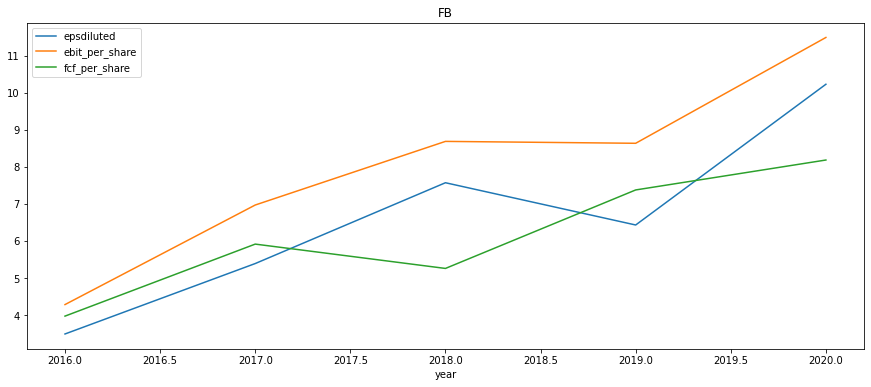

In [ ]:
main_company.fundamentals.df_fundamentals[["epsdiluted", "ebit_per_share", "fcf_per_share"]].plot(figsize=(15, 6), title=main_company.ticker)

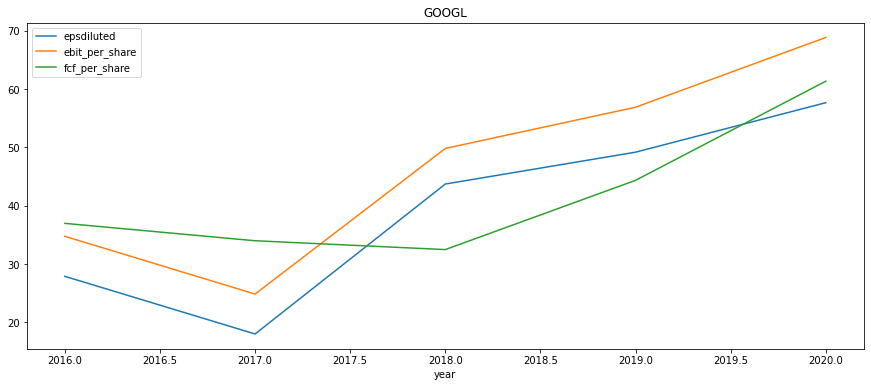

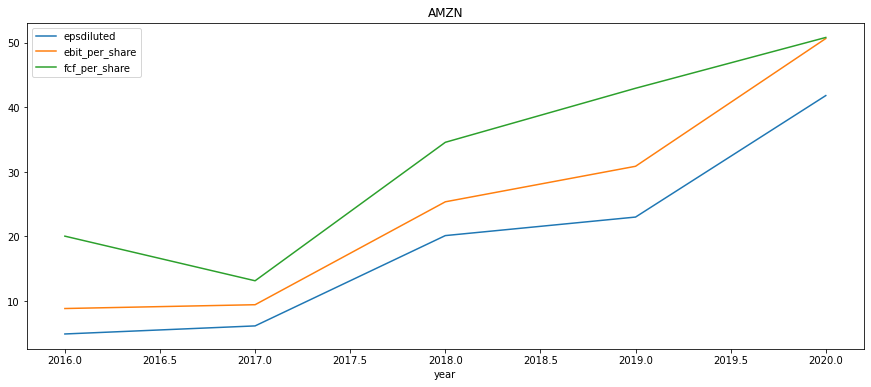

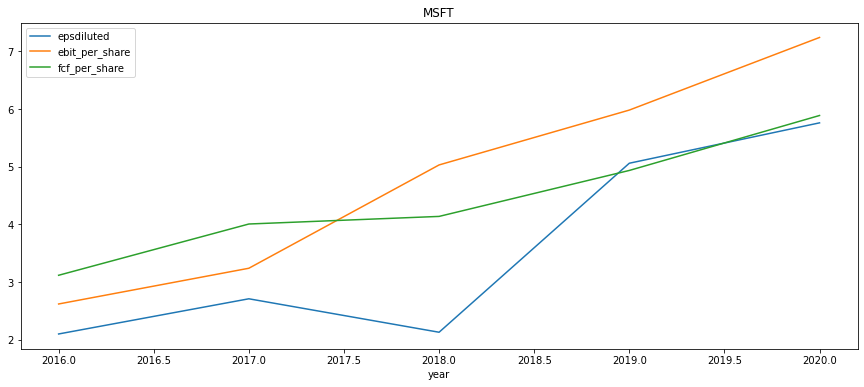

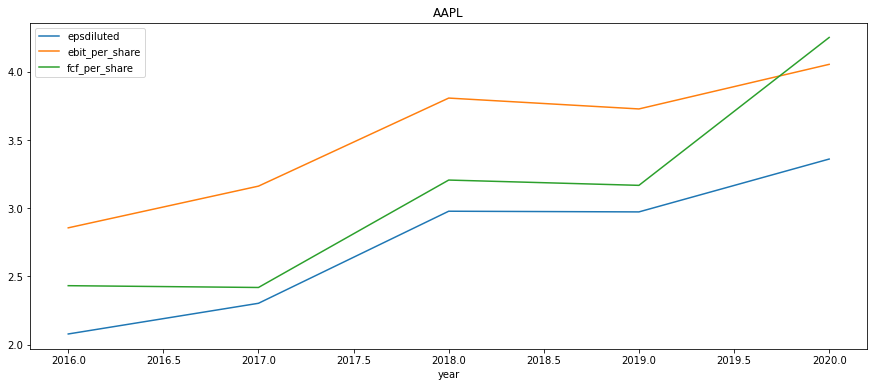

In [ ]:
for comp in competitors:
  comp.fundamentals.df_fundamentals[["epsdiluted", "ebit_per_share", "fcf_per_share"]].plot(figsize=(15, 6), title=comp.ticker)

In [ ]:
print(f"Revenue per share GROWTH CAGR: {main_company.valuation.get_revenue_per_share_growth_cagr_last_five_years() * 100}%")
print(f"EPS per share GROWTH CAGR: {main_company.valuation.get_eps_growth_cagr_last_five_years() * 100}%")
print(f"FCF per share GROWTH CAGR: {main_company.valuation.get_fcf_per_share_growth_cagr_last_five_years() * 100}%")
print(f"EBIT per share GROWTH CAGR: {main_company.valuation.get_ebit_per_share_growth_cagr_last_five_years() * 100}%")

Revenue per share GROWTH CAGR: 26.0%
EPS per share GROWTH CAGR: 24.0%
FCF per share GROWTH CAGR: 16.0%
EBIT per share GROWTH CAGR: 22.0%


In [ ]:
for comp in competitors:
  print(comp.ticker)
  print(f"Revenue per share GROWTH CAGR: {comp.valuation.get_revenue_per_share_growth_cagr_last_five_years() * 100}%")
  print(f"EPS per share GROWTH CAGR: {comp.valuation.get_eps_growth_cagr_last_five_years() * 100}%")
  print(f"FCF per share GROWTH CAGR: {comp.valuation.get_fcf_per_share_growth_cagr_last_five_years() * 100}%")
  print(f"EBIT per share GROWTH CAGR: {comp.valuation.get_ebit_per_share_growth_cagr_last_five_years() * 100}%")  

GOOGL
Revenue per share GROWTH CAGR: 15.0%
EPS per share GROWTH CAGR: 16.0%
FCF per share GROWTH CAGR: 11.0%
EBIT per share GROWTH CAGR: 15.0%
AMZN
Revenue per share GROWTH CAGR: 22.0%
EPS per share GROWTH CAGR: 54.0%
FCF per share GROWTH CAGR: 20.0%
EBIT per share GROWTH CAGR: 42.0%
MSFT
Revenue per share GROWTH CAGR: 12.0%
EPS per share GROWTH CAGR: 22.0%
FCF per share GROWTH CAGR: 14.000000000000002%
EBIT per share GROWTH CAGR: 23.0%
AAPL
Revenue per share GROWTH CAGR: 10.0%
EPS per share GROWTH CAGR: 10.0%
FCF per share GROWTH CAGR: 12.0%
EBIT per share GROWTH CAGR: 7.000000000000001%


# Valuation Analysis

In [ ]:
print(main_company.ticker)
print(f"EPS 5Y forecast: {main_company.valuation.get_eps_five_years_forecast()}")
print(f"EBIT per share 5Y forecast: {main_company.valuation.get_ebit_per_share_five_years_forecast()}")
print(f"EBITDA per share 5Y forecast: {main_company.valuation.get_ebitda_per_share_five_years_forecast()}")
print(f"FCF per share 5Y forecast: {main_company.valuation.get_fcf_per_share_five_years_forecast()}")

FB
EPS 5Y forecast: 19.94
EBIT per share 5Y forecast: 21.83
EBITDA per share 5Y forecast: 26.34
FCF per share 5Y forecast: 13.5


In [ ]:
for comp in competitors:
  print(comp.ticker)
  print(f"EPS 5Y forecast: {comp.valuation.get_eps_five_years_forecast()}")
  print(f"EBIT per share 5Y forecast: {comp.valuation.get_ebit_per_share_five_years_forecast()}")
  print(f"EBITDA per share 5Y forecast: {comp.valuation.get_ebitda_per_share_five_years_forecast()}")
  print(f"FCF per share 5Y forecast: {comp.valuation.get_fcf_per_share_five_years_forecast()}")
  print("-------------------------------------------------------------------")

GOOGL
EPS 5Y forecast: 95.12
EBIT per share 5Y forecast: 110.13
EBITDA per share 5Y forecast: 141.5
FCF per share 5Y forecast: 88.93
-------------------------------------------------------------------
AMZN
EPS 5Y forecast: 131.76
EBIT per share 5Y forecast: 136.81
EBITDA per share 5Y forecast: 225.41
FCF per share 5Y forecast: 91.5
-------------------------------------------------------------------
MSFT
EPS 5Y forecast: 10.94
EBIT per share 5Y forecast: 13.76
EBITDA per share 5Y forecast: 16.48
FCF per share 5Y forecast: 9.13
-------------------------------------------------------------------
AAPL
EPS 5Y forecast: 4.7
EBIT per share 5Y forecast: 5.27
EBITDA per share 5Y forecast: 6.1
FCF per share 5Y forecast: 6.38
-------------------------------------------------------------------


In [ ]:
print(f"PER median last 5Y: {main_company.valuation.get_per_median_five_years()}")
print(f"EV EBITDA median last 5Y: {main_company.valuation.get_ev_ebitda_median_five_years()}")
print(f"EV EBIT median last 5Y: {main_company.valuation.get_ev_ebit_median_five_years()}")
print(f"EV FCF median last 5Y: {main_company.valuation.get_ev_fcf_median_five_years()}")

PER median last 5Y: 31.92
EV EBITDA median last 5Y: 18.16
EV EBIT median last 5Y: 21.92
EV FCF median last 5Y: 25.82


In [ ]:
for comp in competitors:
  print(comp.ticker)
  print(f"PER median last 5Y: {comp.valuation.get_per_median_five_years()}")
  print(f"EV EBITDA median last 5Y: {comp.valuation.get_ev_ebitda_median_five_years()}")
  print(f"EV EBIT median last 5Y: {comp.valuation.get_ev_ebit_median_five_years()}")
  print(f"EV FCF median last 5Y: {comp.valuation.get_ev_fcf_median_five_years()}")
  print("-------------------------------------------------------------------")

GOOGL
PER median last 5Y: 28.43
EV EBITDA median last 5Y: 15.93
EV EBIT median last 5Y: 20.65
EV FCF median last 5Y: 26.49
-------------------------------------------------------------------
AMZN
PER median last 5Y: 80.31
EV EBITDA median last 5Y: 27.8
EV EBIT median last 5Y: 63.02
EV FCF median last 5Y: 42.54
-------------------------------------------------------------------
MSFT
PER median last 5Y: 26.47
EV EBITDA median last 5Y: 14.3
EV EBIT median last 5Y: 19.2
EV FCF median last 5Y: 21.93
-------------------------------------------------------------------
AAPL
PER median last 5Y: 18.84
EV EBITDA median last 5Y: 12.73
EV EBIT median last 5Y: 15.03
EV FCF median last 5Y: 17.69
-------------------------------------------------------------------


In [ ]:
print(f"Price Today: {main_company.stock_price_today}")
print(f"Price forecast 5Y EV EBITDA: {main_company.valuation.get_stock_price_five_years_forecast_ev_ebitda()}")
print(f"Price forecast 5Y EV EBIT: {main_company.valuation.get_stock_price_five_years_forecast_ev_ebit()}")
print(f"Price forecast 5Y PER: {main_company.valuation.get_stock_price_five_years_forecast_pe()}")
print(f"Price forecast 5Y EV FCF: {main_company.valuation.get_stock_price_five_years_forecast_ev_fcf()}")

Price Today: 270.28
Price forecast 5Y EV EBITDA: 478.33
Price forecast 5Y EV EBIT: 478.51
Price forecast 5Y PER: 636.48
Price forecast 5Y EV FCF: 348.57


In [ ]:
for comp in competitors:
  print(comp.ticker)
  print(f"Price Today: {comp.stock_price_today}")
  print(f"Price forecast 5Y EV EBITDA: {comp.valuation.get_stock_price_five_years_forecast_ev_ebitda()}")
  print(f"Price forecast 5Y EV EBIT: {comp.valuation.get_stock_price_five_years_forecast_ev_ebit()}")
  print(f"Price forecast 5Y PER: {comp.valuation.get_stock_price_five_years_forecast_pe()}")
  print(f"Price forecast 5Y EV FCF: {comp.valuation.get_stock_price_five_years_forecast_ev_fcf()}")
  print("-------------------------------------------------------------------")

GOOGL
Price Today: 2083.365
Price forecast 5Y EV EBITDA: 2254.09
Price forecast 5Y EV EBIT: 2274.18
Price forecast 5Y PER: 2704.26
Price forecast 5Y EV FCF: 2355.76
-------------------------------------------------------------------
AMZN
Price Today: 3273.0002
Price forecast 5Y EV EBITDA: 6266.4
Price forecast 5Y EV EBIT: 8621.77
Price forecast 5Y PER: 10581.65
Price forecast 5Y EV FCF: 3892.41
-------------------------------------------------------------------
MSFT
Price Today: 242.072
Price forecast 5Y EV EBITDA: 235.66
Price forecast 5Y EV EBIT: 264.19
Price forecast 5Y PER: 289.58
Price forecast 5Y EV FCF: 200.22
-------------------------------------------------------------------
AAPL
Price Today: 135.21
Price forecast 5Y EV EBITDA: 77.65
Price forecast 5Y EV EBIT: 79.21
Price forecast 5Y PER: 88.55
Price forecast 5Y EV FCF: 112.86
-------------------------------------------------------------------


In [ ]:
print(f"Price Today: {main_company.stock_price_today}")
print(f"CAGR 5Y price EV EBITDA: {main_company.valuation.get_price_five_years_forecast_ev_ebitda_cagr(main_company.stock_price_today) * 100}")
print(f"CAGR 5Y price EV EBIT: {main_company.valuation.get_price_five_years_forecast_ev_ebit_cagr(main_company.stock_price_today) * 100}")
print(f"CAGR 5Y price EV PER: {main_company.valuation.get_price_five_years_forecast_pe_cagr(main_company.stock_price_today) * 100}")
print(f"CAGR 5Y price EV FCF: {main_company.valuation.get_price_five_years_forecast_ev_fcf_cagr(main_company.stock_price_today) * 100}")

Price Today: 270.28
CAGR 5Y price EV EBITDA: 12.0
CAGR 5Y price EV EBIT: 12.0
CAGR 5Y price EV PER: 19.0
CAGR 5Y price EV FCF: 5.0


In [ ]:
for comp in competitors:
  print(comp.ticker)
  print(f"Price Today: {comp.stock_price_today}")
  print(f"CAGR 5Y price EV EBITDA: {comp.valuation.get_price_five_years_forecast_ev_ebitda_cagr(comp.stock_price_today) * 100}")
  print(f"CAGR 5Y price EV EBIT: {comp.valuation.get_price_five_years_forecast_ev_ebit_cagr(comp.stock_price_today) * 100}")
  print(f"CAGR 5Y price EV PER: {comp.valuation.get_price_five_years_forecast_pe_cagr(comp.stock_price_today) * 100}")
  print(f"CAGR 5Y price EV FCF: {comp.valuation.get_price_five_years_forecast_ev_fcf_cagr(comp.stock_price_today) * 100}")
  print("-------------------------------------------------------------------")

GOOGL
Price Today: 2083.365
CAGR 5Y price EV EBITDA: 2.0
CAGR 5Y price EV EBIT: 2.0
CAGR 5Y price EV PER: 5.0
CAGR 5Y price EV FCF: 2.0
-------------------------------------------------------------------
AMZN
Price Today: 3273.0002
CAGR 5Y price EV EBITDA: 14.000000000000002
CAGR 5Y price EV EBIT: 21.0
CAGR 5Y price EV PER: 26.0
CAGR 5Y price EV FCF: 4.0
-------------------------------------------------------------------
MSFT
Price Today: 242.072
CAGR 5Y price EV EBITDA: -1.0
CAGR 5Y price EV EBIT: 2.0
CAGR 5Y price EV PER: 4.0
CAGR 5Y price EV FCF: -4.0
-------------------------------------------------------------------
AAPL
Price Today: 135.21
CAGR 5Y price EV EBITDA: -10.0
CAGR 5Y price EV EBIT: -10.0
CAGR 5Y price EV PER: -8.0
CAGR 5Y price EV FCF: -4.0
-------------------------------------------------------------------


# Margins Analysis



In [ ]:
main_company.fundamentals.df_fundamentals[["margin_gross", "margin_ebit", "margin_net", "margin_fcf"]]

,margin_gross,margin_ebit,margin_net,margin_fcf
year,,,,
2016,86.00,45.00,37.00,42.00
2017,87.00,51.00,39.00,43.00
2018,83.00,45.00,40.00,28.00
2019,82.00,35.00,26.00,30.00
2020,80.00,39.00,34.00,27.00


In [ ]:
for comp in competitors:
  print(comp.ticker)
  display(comp.fundamentals.df_fundamentals[["margin_gross", "margin_ebit", "margin_net", "margin_fcf"]])
  print("--------------------------------------------------------")

GOOGL


,margin_gross,margin_ebit,margin_net,margin_fcf
year,,,,
2016,61.00,27.00,22.00,29.00
2017,59.00,16.00,11.00,22.00
2018,56.00,26.00,22.00,17.00
2019,56.00,25.00,21.00,19.00
2020,54.00,26.00,22.00,23.00


--------------------------------------------------------
AMZN


,margin_gross,margin_ebit,margin_net,margin_fcf
year,,,,
2016,22.00,3.00,2.00,7.00
2017,23.00,3.00,2.00,4.00
2018,26.00,5.00,4.00,7.00
2019,27.00,6.00,4.00,8.00
2020,24.00,7.00,6.00,7.00


--------------------------------------------------------
MSFT


,margin_gross,margin_ebit,margin_net,margin_fcf
year,,,,
2016,62.00,25.00,20.00,29.00
2017,62.00,28.00,24.00,35.00
2018,65.00,36.00,15.00,29.00
2019,66.00,37.00,31.00,30.00
2020,68.00,39.00,31.00,32.00


--------------------------------------------------------
AAPL


,margin_gross,margin_ebit,margin_net,margin_fcf
year,,,,
2016,39.00,29.00,21.00,25.00
2017,38.00,29.00,21.00,22.00
2018,38.00,29.00,22.00,24.00
2019,38.00,27.00,21.00,23.00
2020,38.00,25.00,21.00,27.00


--------------------------------------------------------


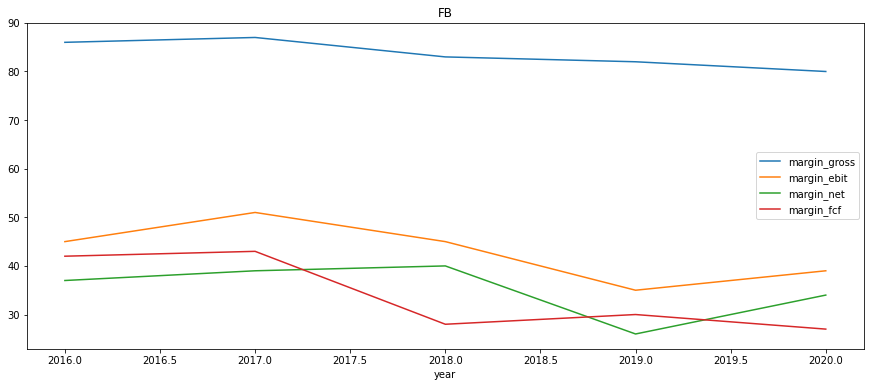

In [ ]:
main_company.fundamentals.df_fundamentals[["margin_gross", "margin_ebit", "margin_net", "margin_fcf"]].plot(figsize=(15, 6), title=main_company.ticker)

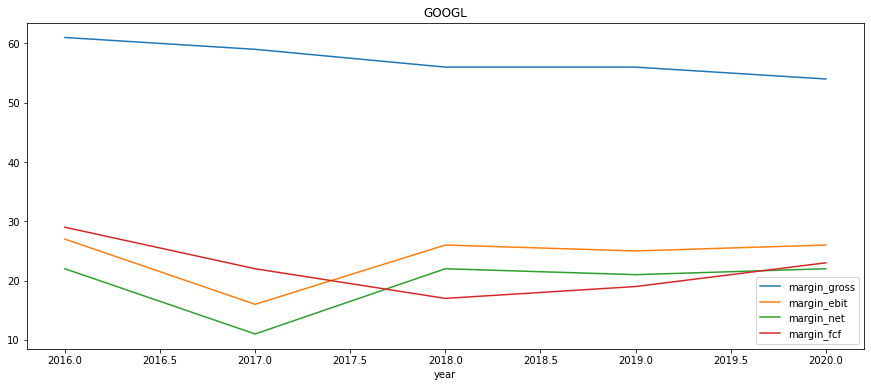

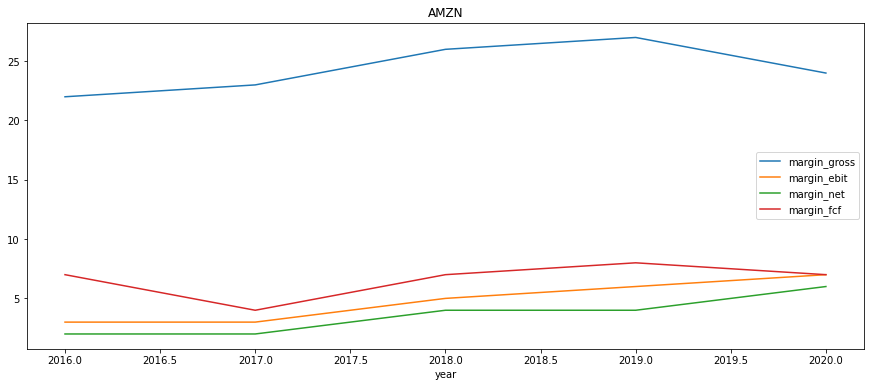

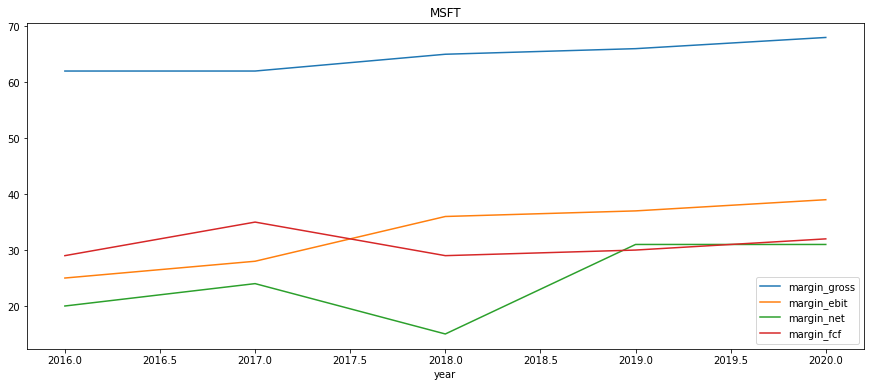

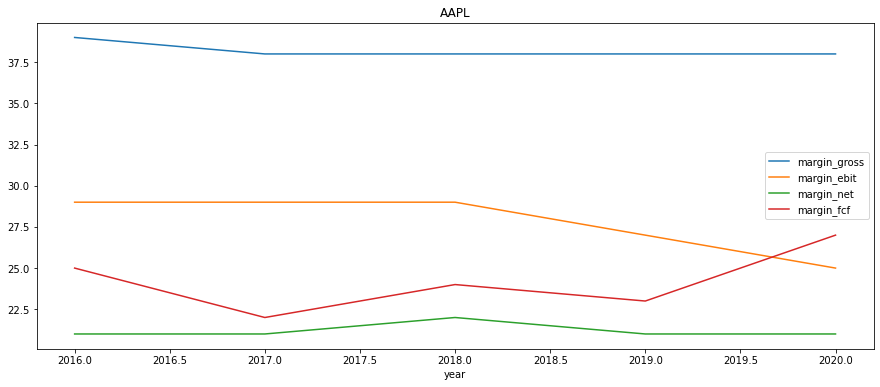

In [ ]:
for comp in competitors:
  comp.fundamentals.df_fundamentals[["margin_gross", "margin_ebit", "margin_net", "margin_fcf"]].plot(figsize=(15, 6), title=comp.ticker)

In [ ]:
print(f"Gross margin: {main_company.fundamentals.get_last_gross_margin()}%")
print(f"EBIT margin: {main_company.fundamentals.get_last_margin_ebit()}%")
print(f"NET margin: {main_company.fundamentals.get_last_margin_net()}%")
print(f"FCF margin: {main_company.fundamentals.get_last_margin_fcf()}%")

Gross margin: 80.0%
EBIT margin: 39.0%
NET margin: 34.0%
FCF margin: 27.0%


In [ ]:
for comp in competitors:
  print(comp.ticker)
  print(f"Gross margin: {comp.fundamentals.get_last_gross_margin()}%")
  print(f"EBIT margin: {comp.fundamentals.get_last_margin_ebit()}%")
  print(f"NET margin: {comp.fundamentals.get_last_margin_net()}%")
  print(f"FCF margin: {comp.fundamentals.get_last_margin_fcf()}%")
  print("---------------------------------------------------")

GOOGL
Gross margin: 54.0%
EBIT margin: 26.0%
NET margin: 22.0%
FCF margin: 23.0%
---------------------------------------------------
AMZN
Gross margin: 24.0%
EBIT margin: 7.0%
NET margin: 6.0%
FCF margin: 7.0%
---------------------------------------------------
MSFT
Gross margin: 68.0%
EBIT margin: 39.0%
NET margin: 31.0%
FCF margin: 32.0%
---------------------------------------------------
AAPL
Gross margin: 38.0%
EBIT margin: 25.0%
NET margin: 21.0%
FCF margin: 27.0%
---------------------------------------------------


# Profitability Analysis


FB


,returnOnAssets,returnOnEquity,returnOnCapitalEmployed
date,,,
2012-12-31,0.35,0.45,3.52
2013-12-31,8.38,9.70,16.40
2014-12-31,7.32,8.14,12.67
2015-12-31,7.46,8.34,13.04
2016-12-31,15.73,17.26,20.16
2017-12-31,18.85,21.43,25.50


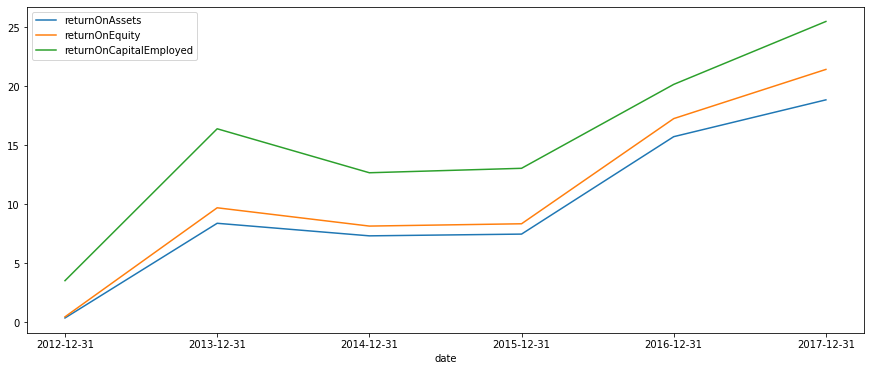

In [ ]:
print(main_company.ticker)
df_returns_reversed = main_company.ratios.df_ratios[["date", "returnOnAssets", "returnOnEquity", "returnOnCapitalEmployed"]].iloc[::-1]
df_returns_reversed = df_returns_reversed.head(6)
df_returns_reversed["returnOnAssets"] = df_returns_reversed["returnOnAssets"] * 100
df_returns_reversed["returnOnEquity"] = df_returns_reversed["returnOnEquity"] * 100
df_returns_reversed["returnOnCapitalEmployed"] = df_returns_reversed["returnOnCapitalEmployed"] * 100
df_returns_reversed.set_index("date", inplace=True)
df_returns_reversed.plot(figsize=(15, 6))
display(df_returns_reversed)

GOOGL


,returnOnAssets,returnOnEquity,returnOnCapitalEmployed
date,,,
2004-12-31,12.04,13.62,21.86
2005-12-31,14.26,15.55,22.48
2006-12-31,16.66,18.06,23.36
2007-12-31,16.59,18.53,24.35
2008-12-31,13.31,14.97,19.87
2009-12-31,16.10,18.11,22.20


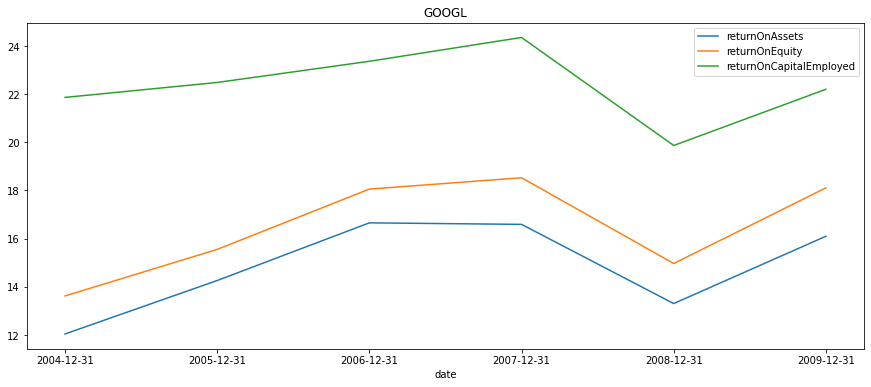

---------------------------------------------------------
AMZN


,returnOnAssets,returnOnEquity,returnOnCapitalEmployed
date,,,
1997-12-31,-18.52,-96.84,0.00
1998-12-31,-19.21,-89.77,0.00
1999-12-31,-29.13,-270.38,0.00
2000-12-31,-66.10,145.91,0.00
2001-12-31,-34.64,39.39,0.00
2002-12-31,-7.49,11.02,0.00


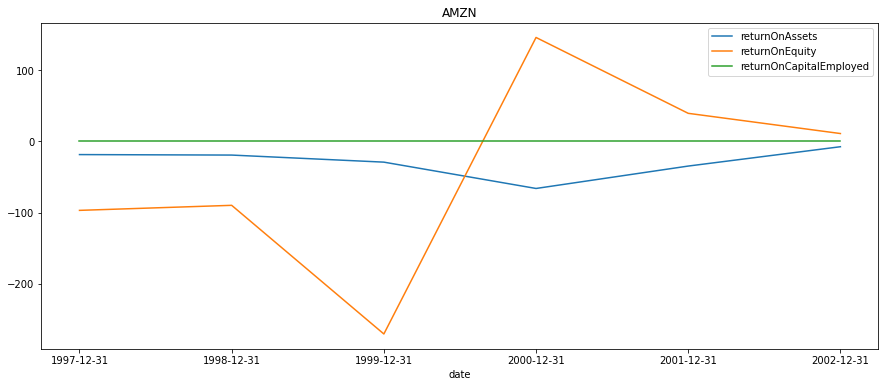

---------------------------------------------------------
MSFT


,returnOnAssets,returnOnEquity,returnOnCapitalEmployed
date,,,
1987-06-30,25.00,30.13,50.63
1988-06-30,25.15,33.07,49.07
1989-06-30,23.72,30.43,44.66
1990-06-30,25.25,30.36,44.77
1991-06-30,28.16,34.27,49.67
1992-06-30,26.82,32.28,47.47


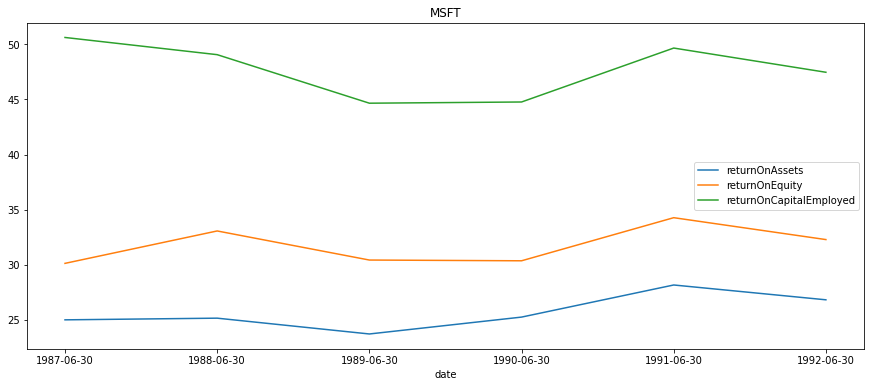

---------------------------------------------------------
AAPL


,returnOnAssets,returnOnEquity,returnOnCapitalEmployed
date,,,
1985-09-27,6.52,11.09,18.72
1986-09-26,13.28,22.19,37.30
1987-09-25,14.68,25.96,41.04
1988-09-30,19.21,39.88,52.27
1989-09-29,16.55,30.55,40.24
1989-09-30,16.55,30.56,40.26


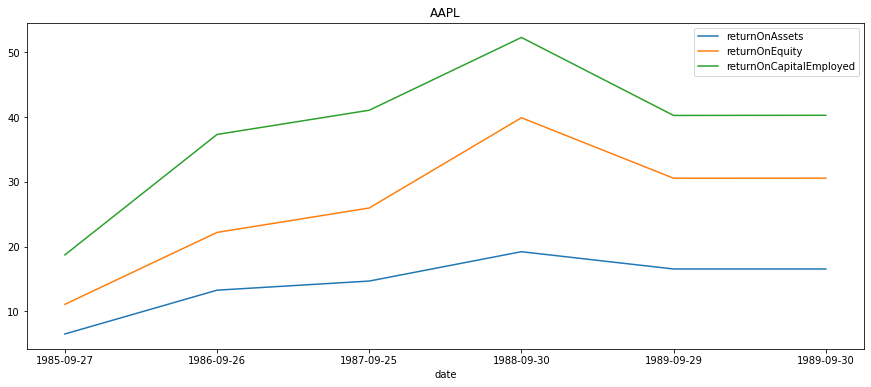

---------------------------------------------------------


In [ ]:
for comp in competitors:
  print(comp.ticker)
  df_returns_reversed = comp.ratios.df_ratios[["date", "returnOnAssets", "returnOnEquity", "returnOnCapitalEmployed"]].iloc[::-1]
  df_returns_reversed = df_returns_reversed.head(6)
  df_returns_reversed["returnOnAssets"] = df_returns_reversed["returnOnAssets"] * 100
  df_returns_reversed["returnOnEquity"] = df_returns_reversed["returnOnEquity"] * 100
  df_returns_reversed["returnOnCapitalEmployed"] = df_returns_reversed["returnOnCapitalEmployed"] * 100
  df_returns_reversed.set_index("date", inplace=True)
  df_returns_reversed.plot(figsize=(15, 6), title=comp.ticker)
  display(df_returns_reversed)
  plt.show() 
  print("---------------------------------------------------------")

,roic
date,
2012-12-31,3.52
2013-12-31,16.40
2014-12-31,12.67
2015-12-31,13.04
2016-12-31,20.16
2017-12-31,25.50
2018-12-31,28.08
2019-12-31,20.97
2020-12-31,22.99


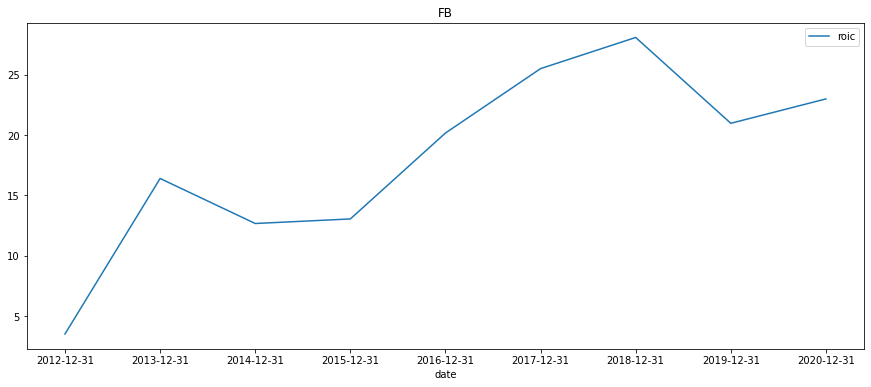

In [ ]:
df_roic_reversed = main_company.ratios.df_key_metrics.iloc[::-1][["date", "roic"]]
df_roic_reversed["roic"] = df_roic_reversed["roic"] * 100
df_roic_reversed.set_index("date", inplace=True)
df_roic_reversed.plot(figsize=(15, 6), title=main_company.ticker)
display(df_roic_reversed)
plt.show()

,roic
date,
2004-12-31,21.86
2005-12-31,22.48
2006-12-31,23.36
2007-12-31,24.35
2008-12-31,19.87
2009-12-31,22.20
2010-12-31,22.56
2011-12-31,19.36
2012-12-31,18.21


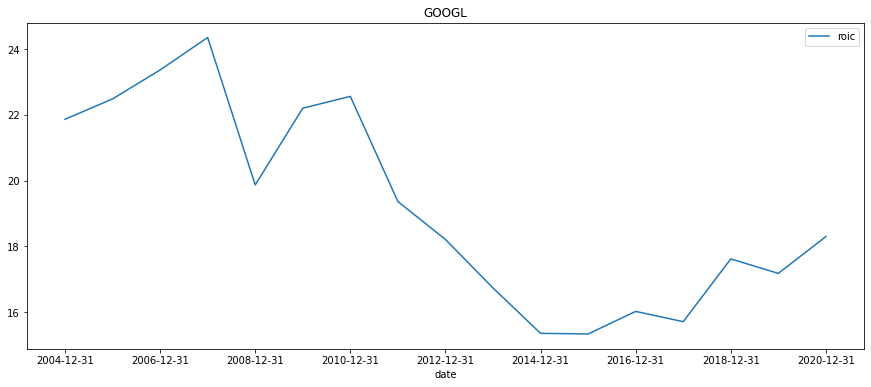

,roic
date,
1997-12-31,0.00
1998-12-31,0.00
1999-12-31,0.00
2000-12-31,0.00
2001-12-31,0.00
2002-12-31,0.00
2003-12-31,0.00
2004-12-31,21.86
2005-12-31,24.22


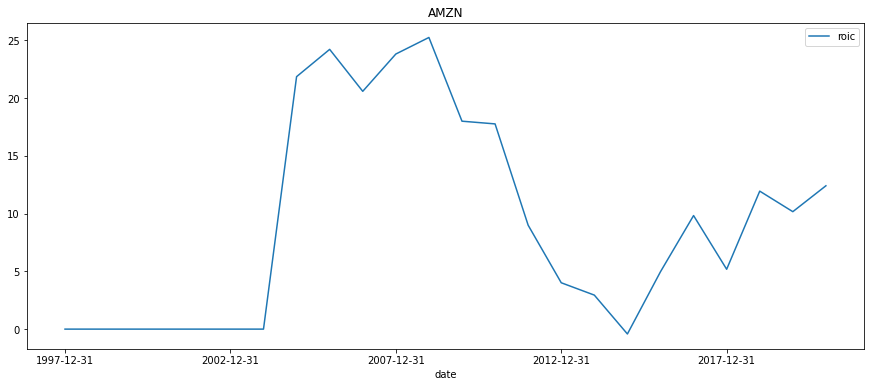

,roic
date,
1987-06-30,50.63
1988-06-30,49.07
1989-06-30,44.66
1990-06-30,44.77
1991-06-30,49.67
1992-06-30,47.47
1993-06-30,43.21
1994-06-30,38.70
1995-06-30,36.96


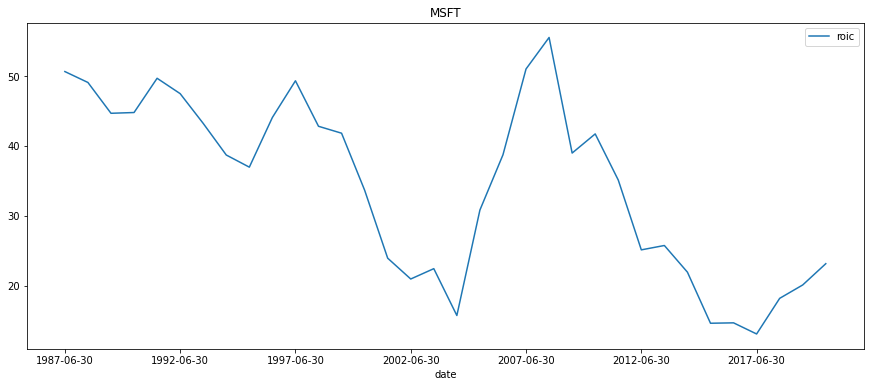

,roic
date,
1985-09-27,18.72
1986-09-26,37.30
1987-09-25,41.04
1988-09-30,52.27
1989-09-29,40.24
1989-09-30,40.26
1990-09-28,39.97
1990-09-30,39.95
1991-09-27,21.96


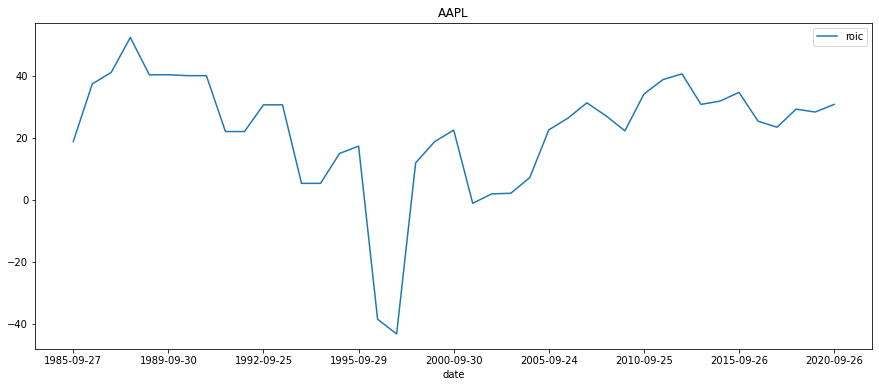

In [ ]:
for comp in competitors:
  df_roic_reversed = comp.ratios.df_key_metrics.iloc[::-1][["date", "roic"]]
  df_roic_reversed["roic"] = df_roic_reversed["roic"] * 100
  df_roic_reversed.set_index("date", inplace=True)
  df_roic_reversed.plot(figsize=(15, 6), title=comp.ticker)
  display(df_roic_reversed)
  plt.show()

# Financial Health Analysis


In [ ]:
display(main_company.fundamentals.df_fundamentals[["shortTermDebt", "longTermDebt", "totalDebt", "cashAndCashEquivalents"]])

,shortTermDebt,longTermDebt,totalDebt,cashAndCashEquivalents
year,,,,
2016,20546000000,0.00,0.00,8903000000
2017,33632000000,0.00,0.00,8079000000
2018,31095000000,0.00,500000000.00,10019000000
2019,35776000000,0.00,10601000000.00,19079000000
2020,1023000000,9631000000.00,10654000000.00,17576000000


In [ ]:
for comp in competitors:
  print(comp.ticker)
  display(comp.fundamentals.df_fundamentals[["shortTermDebt", "longTermDebt", "totalDebt", "cashAndCashEquivalents"]])
  print("------------------------------------------------------------------------")

GOOGL


,shortTermDebt,longTermDebt,totalDebt,cashAndCashEquivalents
year,,,,
2016,0,3935000000,3935000000,12918000000
2017,0,3969000000,3969000000,10715000000
2018,0,4012000000,4012000000,16701000000
2019,0,4554000000,4554000000,18498000000
2020,110229000000,13932000000,25078000000,26465000000


------------------------------------------------------------------------
AMZN


,shortTermDebt,longTermDebt,totalDebt,cashAndCashEquivalents
year,,,,
2016,6647000000,7694000000,15213000000,19334000000
2017,10464000000,24743000000,37926000000,20522000000
2018,9500000000,23495000000,39787000000,31750000000
2019,18929000000,23414000000,63205000000,36092000000
2020,42274000000,31816000000,84389000000,42122000000


------------------------------------------------------------------------
MSFT


,shortTermDebt,longTermDebt,totalDebt,cashAndCashEquivalents
year,,,,
2016,106730000000,40783000000,53687000000,6510000000
2017,125318000000,76073000000,86194000000,7663000000
2018,121822000000,72242000000,81808000000,11946000000
2019,122463000000,66662000000,78366000000,11356000000
2020,122951000000,59578000000,70998000000,13576000000


------------------------------------------------------------------------
AAPL


,shortTermDebt,longTermDebt,totalDebt,cashAndCashEquivalents
year,,,,
2016,8105000000,3500000000,87032000000,20484000000
2017,11977000000,6496000000,115680000000,20289000000
2018,11964000000,93735000000,114483000000,25913000000
2019,5980000000,91807000000,108047000000,48844000000
2020,4996000000,98667000000,112436000000,38016000000


------------------------------------------------------------------------


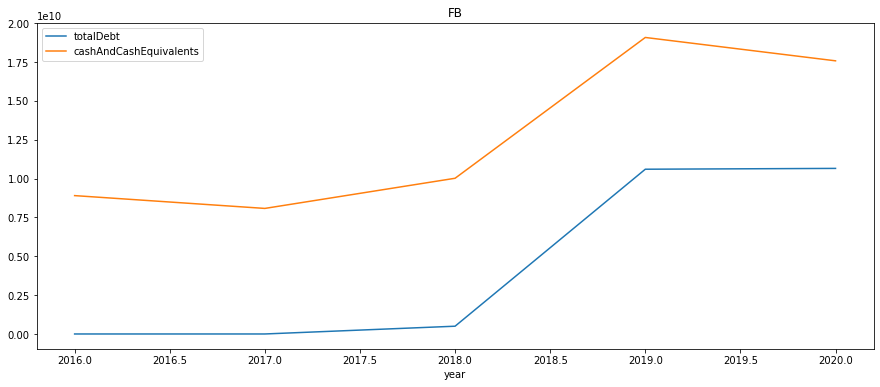

In [ ]:
main_company.fundamentals.df_fundamentals[["totalDebt", "cashAndCashEquivalents"]].plot(figsize=(15, 6), title=main_company.ticker)

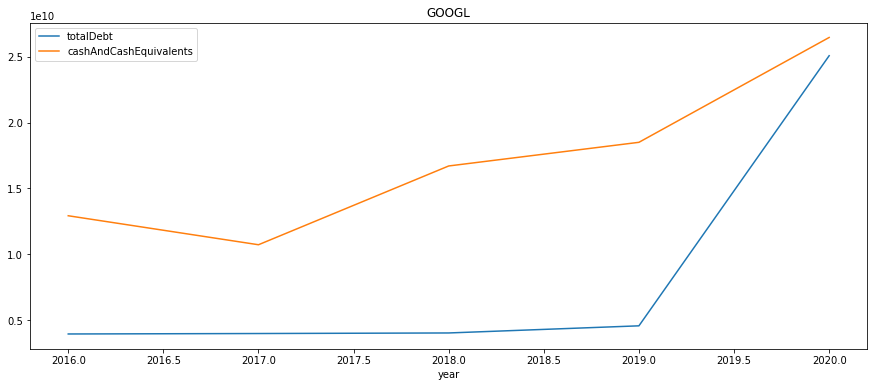

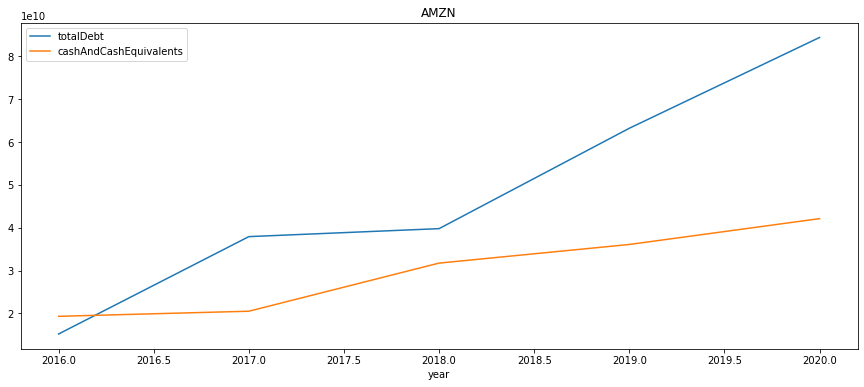

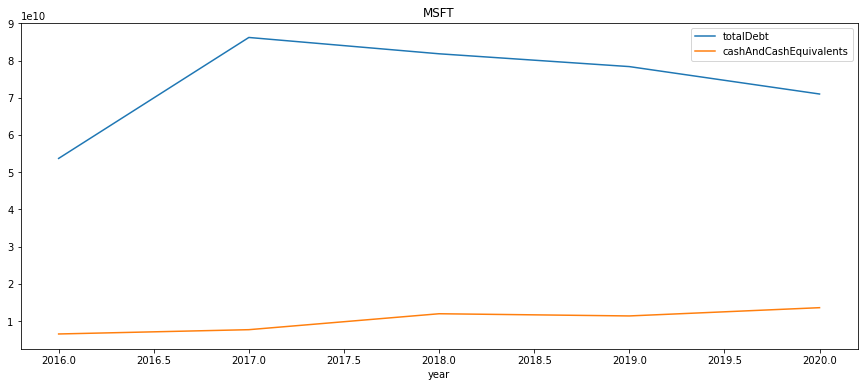

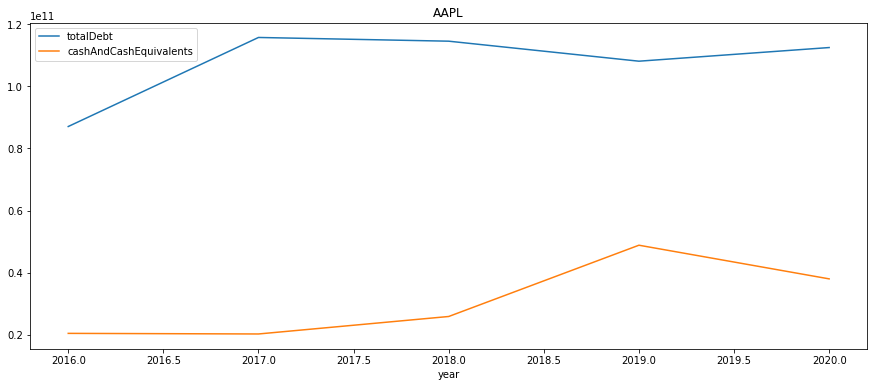

In [ ]:
for comp in competitors:
  comp.fundamentals.df_fundamentals[["totalDebt", "cashAndCashEquivalents"]].plot(figsize=(15, 6), title=comp.ticker)

¿La cobertura de intereses por parte del EBIT = EBIT/Total de intereses a pagar está por encima de 5 veces?

,interestCoverage
date,
2012-12-31,9.69
2013-12-31,49.18
2014-12-31,213.48
2015-12-31,269.30
2016-12-31,1251.80
2017-12-31,3432.33
2018-12-31,2817.89
2019-12-31,1240.60
2020-12-31,nan


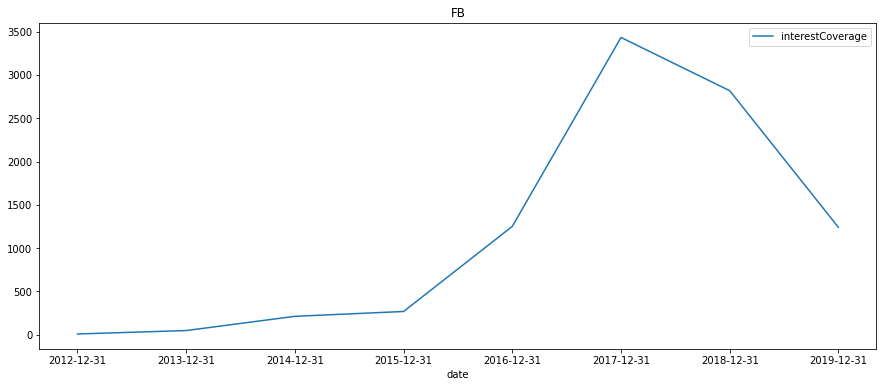

In [ ]:
df_interest_coverage = main_company.ratios.df_ratios[["date", "interestCoverage"]].iloc[::-1]
df_interest_coverage.set_index("date", inplace=True)
display(df_interest_coverage)
df_interest_coverage.plot(figsize=(15, 6), title=main_company.ticker)

GOOGL


,interestCoverage
date,
2004-12-31,43.33
2005-12-31,17.85
2006-12-31,8.76
2007-12-31,9.55
2008-12-31,18.76
2009-12-31,125.09
2010-12-31,26.72
2011-12-31,19.60
2012-12-31,-99.79


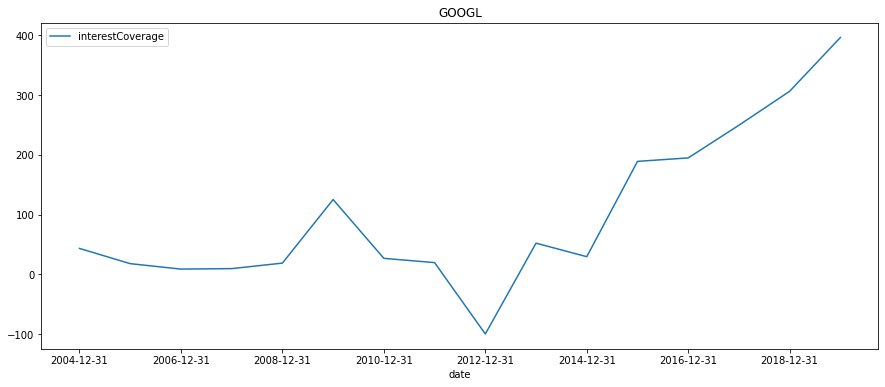

------------------------------------------------------
AMZN


,interestCoverage
date,
1997-12-31,nan
1998-12-31,nan
1999-12-31,nan
2000-12-31,nan
2001-12-31,nan
2002-12-31,nan
2003-12-31,nan
2004-12-31,nan
2005-12-31,nan


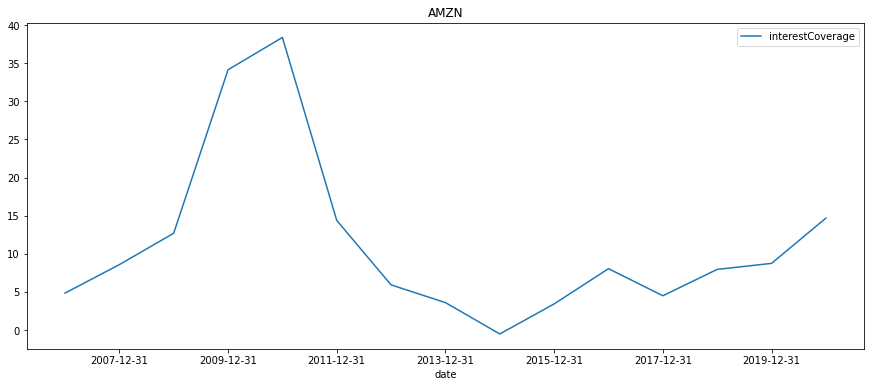

------------------------------------------------------
MSFT


,interestCoverage
date,
1987-06-30,nan
1988-06-30,nan
1989-06-30,13.21
1990-06-30,13.26
1991-06-30,18.14
1992-06-30,18.59
1993-06-30,17.09
1994-06-30,nan
1995-06-30,nan


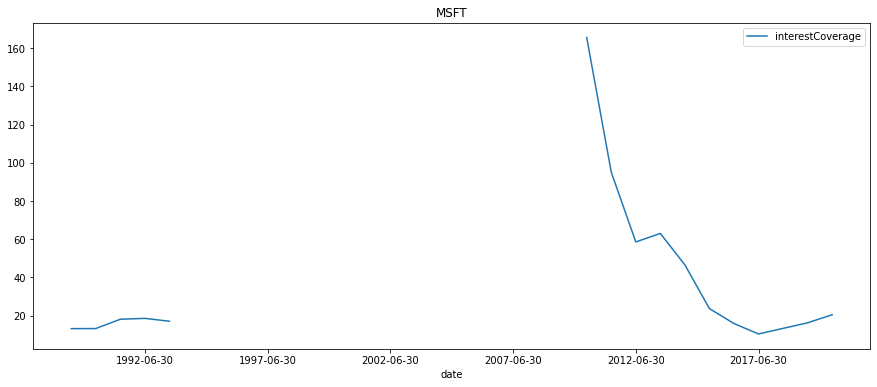

------------------------------------------------------
AAPL


,interestCoverage
date,
1985-09-27,nan
1986-09-26,nan
1987-09-25,nan
1988-09-30,nan
1989-09-29,nan
1989-09-30,nan
1990-09-28,nan
1990-09-30,nan
1991-09-27,nan


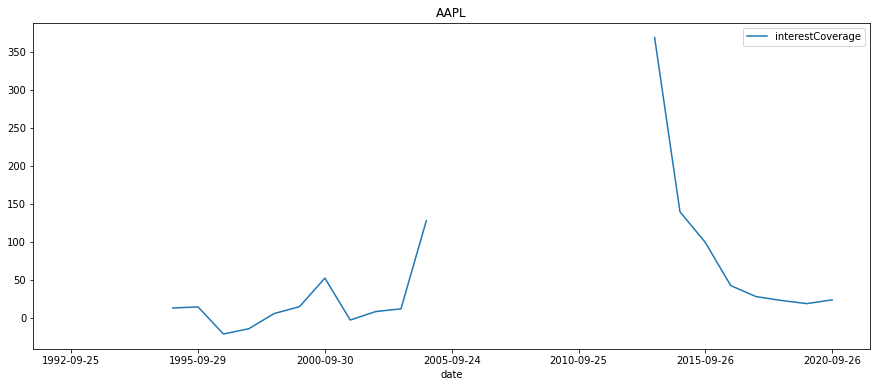

------------------------------------------------------


In [ ]:
for comp in competitors:
  print(comp.ticker)
  df_interest_coverage = comp.ratios.df_ratios[["date", "interestCoverage"]].iloc[::-1]
  df_interest_coverage.set_index("date", inplace=True)
  display(df_interest_coverage)
  df_interest_coverage.plot(figsize=(15, 6), title=comp.ticker)
  plt.show()
  print("------------------------------------------------------") 

**CURRENT RATIO should be > 1**

,currentRatio
date,
2012-12-31,10.71
2013-12-31,11.88
2014-12-31,9.60
2015-12-31,11.25
2016-12-31,11.97
2017-12-31,12.92
2018-12-31,7.19
2019-12-31,4.40
2020-12-31,5.05


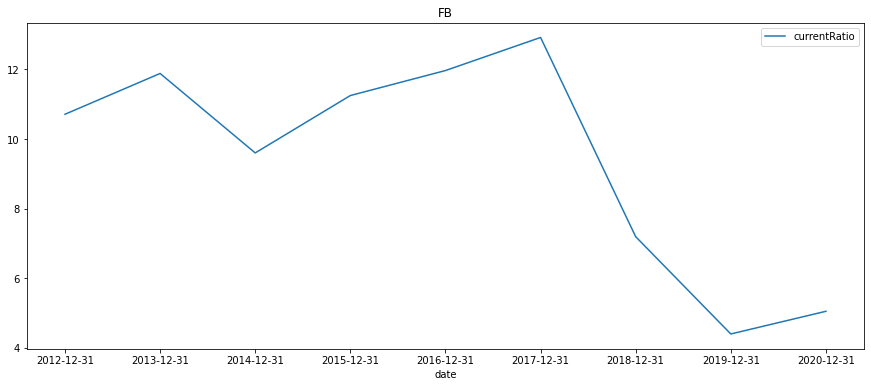

In [ ]:
df_current_ratio_reversed = main_company.ratios.df_ratios[["date", "currentRatio"]].iloc[::-1]
df_current_ratio_reversed.set_index("date", inplace=True)
display(df_current_ratio_reversed)
df_current_ratio_reversed.plot(figsize=(15, 6), title=main_company.ticker)

,currentRatio
date,
2004-12-31,7.92
2005-12-31,12.08
2006-12-31,9.99
2007-12-31,8.49
2008-12-31,8.77
2009-12-31,10.62
2010-12-31,4.16
2011-12-31,5.92
2012-12-31,4.22


,currentRatio
date,
1997-12-31,3.13
1998-12-31,2.63
1999-12-31,1.37
2000-12-31,1.40
2001-12-31,1.31
2002-12-31,1.52
2003-12-31,1.45
2004-12-31,1.57
2005-12-31,1.52


,currentRatio
date,
1987-06-30,4.35
1988-06-30,2.92
1989-06-30,2.95
1990-06-30,3.85
1991-06-30,3.51
1992-06-30,3.96
1993-06-30,5.06
1994-06-30,4.72
1995-06-30,4.17


,currentRatio
date,
1985-09-27,2.79
1986-09-26,3.16
1987-09-25,2.73
1988-09-30,2.16
1989-09-29,2.56
1989-09-30,2.56
1990-09-28,2.34
1990-09-30,2.34
1991-09-27,2.35


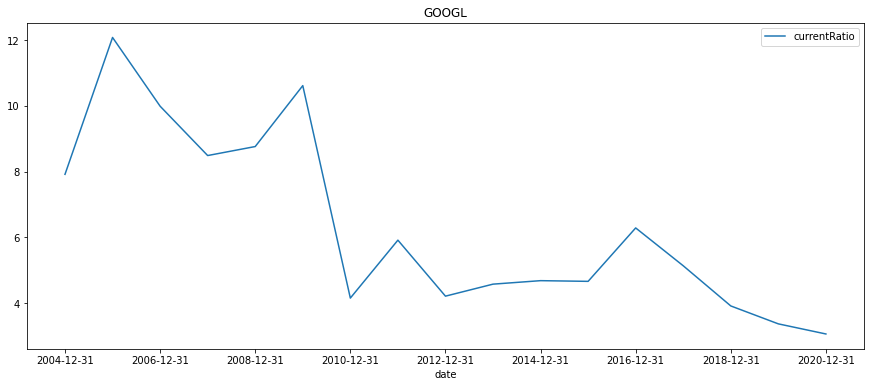

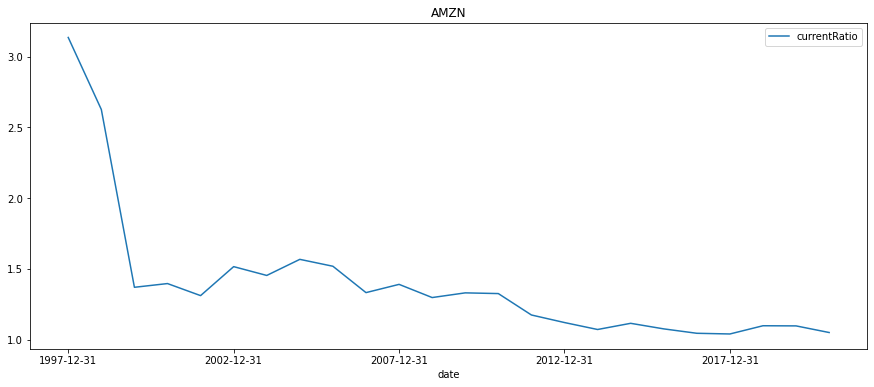

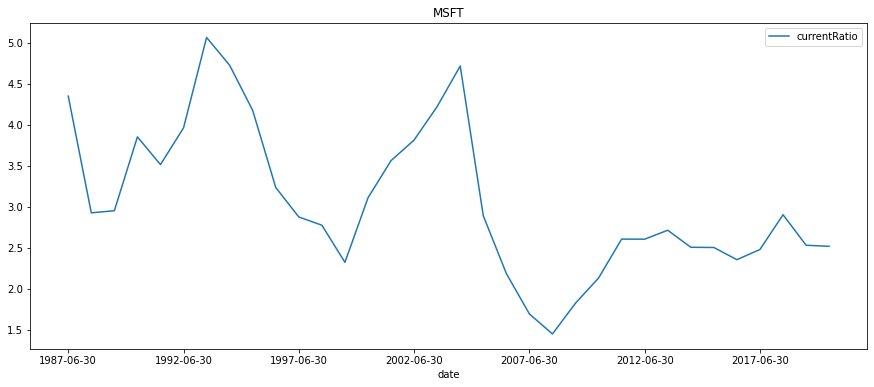

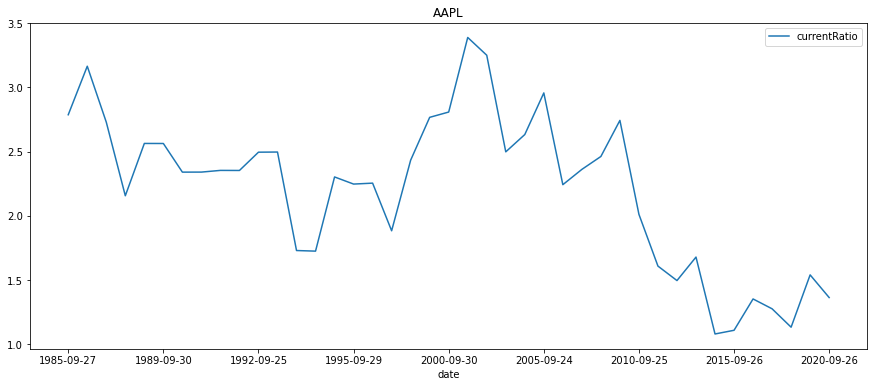

In [ ]:
for comp in competitors:
  df_current_ratio_reversed = comp.ratios.df_ratios[["date", "currentRatio"]].iloc[::-1]
  df_current_ratio_reversed.set_index("date", inplace=True)
  display(df_current_ratio_reversed)
  df_current_ratio_reversed.plot(figsize=(15, 6), title=comp.ticker)